In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from vit_pytorch import ViT
import tensorflow as tf
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc
import seaborn as sns


In [2]:
tf.config.list_physical_devices('GPU')
len(tf.config.list_physical_devices('GPU'))


0

In [3]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu102
0.11.0+cu102


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [5]:
print(torch.cuda.is_available())


True


In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.10.0+cu102
10.2


In [14]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1050'

In [15]:
# Define dataset class
class LungNoduleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            for image_path in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, image_path))
                self.labels.append(int(label == 'NOD'))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [16]:
# Define data transformations for original images
orig_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [17]:
# Define data transformations for augmented images
augment_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [18]:
# Define data transformations for augmented images
augment_transform2 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [19]:
# Define data transformations for augmented images
augment_transform3 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Define data transformations for augmented images
augment_transform4 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [20]:
# Load original dataset
root_dir = r'C:\Users\dali_\OneDrive\Bureau\5edma\PPP\DATA_LIDC_IDRI'
orig_dataset = LungNoduleDataset(root_dir, transform=orig_transform)


In [21]:
# Augment dataset
augment_dataset = LungNoduleDataset(root_dir, transform=augment_transform)
augment_dataset2 = LungNoduleDataset(root_dir, transform=augment_transform2)
augment_dataset3 = LungNoduleDataset(root_dir, transform=augment_transform3)
augment_dataset4 = LungNoduleDataset(root_dir, transform=augment_transform4)

In [22]:
# Concatenate datasets
full_dataset = torch.utils.data.ConcatDataset([orig_dataset, augment_dataset, augment_dataset2, augment_dataset3, augment_dataset4])

In [23]:
# Split into train, validation and test sets
#train_set, test_set = train_test_split(full_dataset, test_size=0.2, random_state=42)
# train_set, val_set = train_test_split(full_dataset, test_size=0.2, random_state=42)

In [24]:
# Obtain the labels and corresponding indices from the full dataset
labels = [sample[1] for sample in full_dataset]
indices = list(range(len(full_dataset)))

# Create a dictionary to store the indices of samples for each class
class_indices = defaultdict(list)
for i, label in enumerate(labels):
    class_indices[label].append(indices[i])

# Split the indices for each class using stratified sampling
train_indices = []
val_indices = []
test_indices = []
for class_label, indices in class_indices.items():
    train_class, test_class = train_test_split(indices, test_size=0.05, random_state=42)
    train_class, val_class = train_test_split(train_class, test_size=0.1, random_state=42)
    train_indices.extend(train_class)
    val_indices.extend(val_class)
    test_indices.extend(test_class)

# Create the train, validation, and test datasets using the sampled indices
train_set = torch.utils.data.Subset(full_dataset, train_indices)
val_set = torch.utils.data.Subset(full_dataset, val_indices)
test_set = torch.utils.data.Subset(full_dataset, test_indices)

# Count the number of images for each class in the training set
train_counts = defaultdict(int)
for _, label in train_set:
    train_counts[label] += 1

# Count the number of images for each class in the validation set
val_counts = defaultdict(int)
for _, label in val_set:
    val_counts[label] += 1

# Print the number of images for each class in the training set
print("Training Set:")
for label, count in train_counts.items():
    print(f"Class {label}: {count} images")

# Print the number of images for each class in the validation set
print("\nValidation Set:")
for label, count in val_counts.items():
    print(f"Class {label}: {count} images")

Training Set:
Class 1: 4967 images
Class 0: 4911 images

Validation Set:
Class 1: 552 images
Class 0: 546 images


In [25]:
# Define data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [26]:
# Load ViT-Ti/4 model
model = ViT(
    image_size=64,
    patch_size=4,
    num_classes=2,
    dim=128,
    depth=8,
    heads=8,
    mlp_dim=128,
    dropout=0.1,
    emb_dropout=0.1
    ).to(device)

In [27]:
# Define loss function, optimizer, and learning rate
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [28]:
# Lists to store the training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [29]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_loss /= len(train_set)
    train_accuracy = 100 * train_correct / total_samples

    # Validate the model
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
    val_loss /= len(val_set)
    val_accuracy = 100 * val_correct / len(val_set)

    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    model.train()

Epoch [1/100], Train Loss: 0.7030, Train Accuracy: 51.34%
Epoch [1/100], Val Loss: 0.6799, Val Accuracy: 57.56%
Epoch [2/100], Train Loss: 0.6228, Train Accuracy: 63.87%
Epoch [2/100], Val Loss: 0.6089, Val Accuracy: 67.76%
Epoch [3/100], Train Loss: 0.5432, Train Accuracy: 73.01%
Epoch [3/100], Val Loss: 0.5518, Val Accuracy: 74.86%
Epoch [4/100], Train Loss: 0.5253, Train Accuracy: 74.76%
Epoch [4/100], Val Loss: 0.5224, Val Accuracy: 74.77%
Epoch [5/100], Train Loss: 0.5169, Train Accuracy: 75.60%
Epoch [5/100], Val Loss: 0.5205, Val Accuracy: 76.41%
Epoch [6/100], Train Loss: 0.4966, Train Accuracy: 76.39%
Epoch [6/100], Val Loss: 0.5044, Val Accuracy: 77.50%
Epoch [7/100], Train Loss: 0.4910, Train Accuracy: 76.85%
Epoch [7/100], Val Loss: 0.5064, Val Accuracy: 77.60%
Epoch [8/100], Train Loss: 0.4842, Train Accuracy: 76.92%
Epoch [8/100], Val Loss: 0.4891, Val Accuracy: 77.41%
Epoch [9/100], Train Loss: 0.4728, Train Accuracy: 77.81%
Epoch [9/100], Val Loss: 0.4771, Val Accuracy:

Epoch [74/100], Train Loss: 0.1432, Train Accuracy: 94.08%
Epoch [74/100], Val Loss: 0.0885, Val Accuracy: 95.72%
Epoch [75/100], Train Loss: 0.1374, Train Accuracy: 94.54%
Epoch [75/100], Val Loss: 0.1088, Val Accuracy: 95.72%
Epoch [76/100], Train Loss: 0.1360, Train Accuracy: 94.64%
Epoch [76/100], Val Loss: 0.1156, Val Accuracy: 95.81%
Epoch [77/100], Train Loss: 0.1417, Train Accuracy: 94.26%
Epoch [77/100], Val Loss: 0.1154, Val Accuracy: 95.63%
Epoch [78/100], Train Loss: 0.1315, Train Accuracy: 94.93%
Epoch [78/100], Val Loss: 0.0814, Val Accuracy: 96.54%
Epoch [79/100], Train Loss: 0.1317, Train Accuracy: 94.79%
Epoch [79/100], Val Loss: 0.1011, Val Accuracy: 96.27%
Epoch [80/100], Train Loss: 0.1314, Train Accuracy: 94.77%
Epoch [80/100], Val Loss: 0.0964, Val Accuracy: 96.17%
Epoch [81/100], Train Loss: 0.1303, Train Accuracy: 94.53%
Epoch [81/100], Val Loss: 0.0917, Val Accuracy: 97.09%
Epoch [82/100], Train Loss: 0.1285, Train Accuracy: 94.92%
Epoch [82/100], Val Loss: 0.0

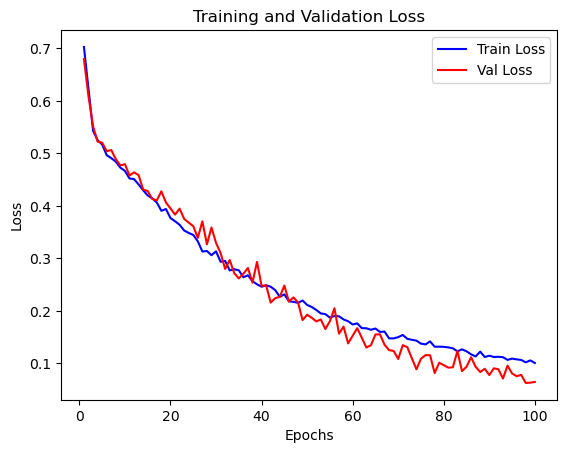

In [30]:
# Plot the curves
epochs = range(1, num_epochs + 1)

# Plot loss curves
plt.figure()
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

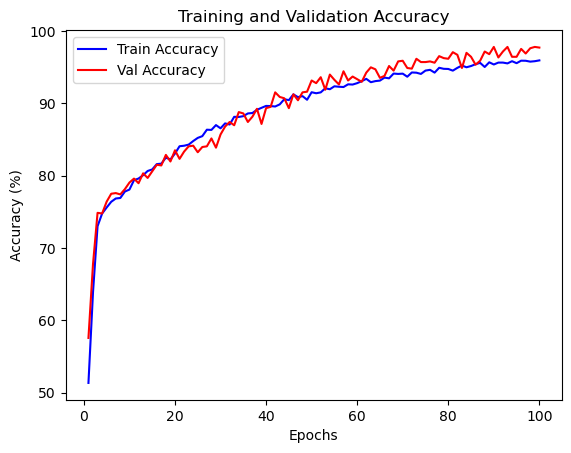

In [31]:
# Plot accuracy curves
plt.figure()
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [32]:
# Evaluate the model on the test set
test_correct = 0
model.eval()
test_predicted = []
test_ground_truth = []
test_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()
        # Append the predicted and ground truth labels to the respective lists
        test_predicted.extend(predicted.cpu().numpy())
        test_ground_truth.extend(labels.cpu().numpy())
        test_probs.extend(probabilities[:, 1].cpu().numpy())  # Probability for class 1 (positive)
test_accuracy = 100 * test_correct / len(test_set)
print(f'Test Accuracy: {test_accuracy:.2f}%')
test_sensitivity = recall_score(test_ground_truth, test_predicted, pos_label=0)
test_specificity = recall_score(test_ground_truth, test_predicted, pos_label=1)
test_f1_score = f1_score(test_ground_truth, test_predicted)
print(f'Test Sensitivity: {test_sensitivity:.2f}')
print(f'Test Specificity: {test_specificity:.2f}')
print(f'Test F1 Score: {test_f1_score:.2f}')

Test Accuracy: 97.58%
Test Sensitivity: 0.95
Test Specificity: 1.00
Test F1 Score: 0.98


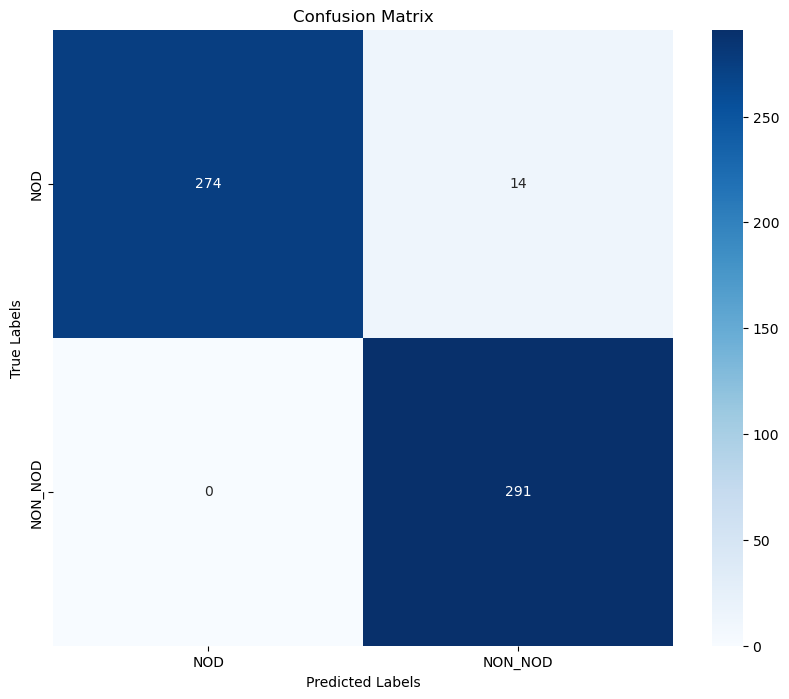

In [33]:
# confusion matrix
cm = confusion_matrix(test_ground_truth, test_predicted)
# Set the class labels
class_labels = ['NOD','NON_NOD']  # List of class labels in the order they appear in the confusion matrix

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

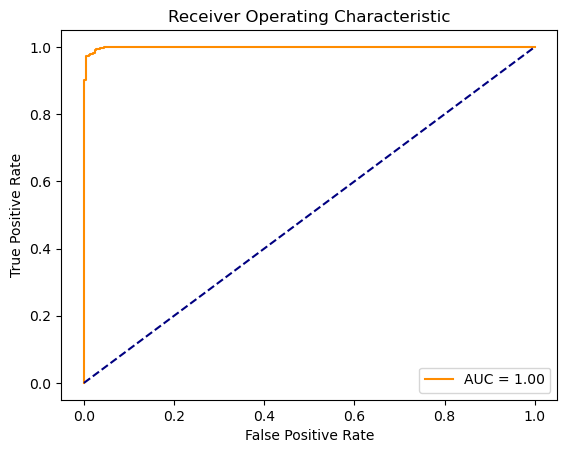

In [34]:
# Compute false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(test_ground_truth, test_probs)

# Compute area under the ROC curve (AUC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [35]:
torch.save(model.state_dict(), 'My_Ultimate_Model.pth')